Import all relevant libraries

In [0]:
import pandas as pd
import numpy as np
import cv2
import math
import matplotlib.pyplot as plt
%matplotlib inline


#directories
import os
from os import listdir
from os.path import isfile, join

import itertools
from skimage import color
from skimage import io
from sklearn.model_selection import train_test_split
from skimage import img_as_ubyte
\
import skimage.transform
from sklearn.metrics import confusion_matrix
from keras.models import Model

import keras
from keras.models import Sequential
from keras.models import model_from_json
from keras.models import Sequential
from keras.layers import Activation
from keras.layers.core import Dense , Flatten
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import *
from keras.layers import GlobalAveragePooling2D
from keras.callbacks import EarlyStopping
from keras.layers import Conv2D ,Dropout
# from keras.layers import 

# for saving model
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive 
from google.colab import auth 
from oauth2client.client import GoogleCredentials
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()                       
drive = GoogleDrive(gauth)

Using TensorFlow backend.


In [0]:
classes = ['ardhabaddhapadmottanasana','ekapadabakasana','natarajasana',
           'parivrttaardhachandrasana','parivrttasuryayantrasana','salambasirsasana',
           'svargadvijasana','tittibihasana','vrishchikasana','vyaghrasana']

Initiate batch import

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
drive_path = '/content/drive/My Drive/General Assembly/Data Science/Capstone/6 image classes/'
cat_1_folder  = drive_path + '500_ardhabaddhapadmottanasana/'
cat_2_folder  = drive_path + '500_ekapadabakasana/'
cat_3_folder  = drive_path + '500_natarajasana/'
cat_4_folder  = drive_path + '500_parivrttaardhachandrasana/'
cat_5_folder  = drive_path + '500_parivrttasuryayantrasana/'
cat_6_folder  = drive_path + '500_salambasirsasana/'
cat_7_folder  = drive_path + '500_svargadvijasana/'
cat_8_folder  = drive_path + '500_tittibihasana/'
cat_9_folder  = drive_path + '500_vrishchikasana/'
cat_10_folder = drive_path + '500_vyaghrasana/'

In [0]:
folders_path = [cat_1_folder,cat_2_folder,cat_3_folder, 
                cat_4_folder, cat_5_folder, cat_6_folder, 
                cat_7_folder, cat_8_folder, cat_9_folder, cat_10_folder ]

In [0]:
all_images =[]
for i,path in enumerate(folders_path):
  ls = []
  for f in listdir(path):
    if isfile(join(path, f)):
      if 'DS' not in f:
        if '._' not in f:
          ls.append([path+f,f,classes[i]])
    # ls = [[path+f,f,classes[i]] for f in listdir(path) if isfile(join(path, f)) if ('DS' or '._' ) not in f ]
  print('{} ,numer of images for {} : {}'.format(i+1,classes[i],len(ls)))
  all_images.extend(ls)


1 ,numer of images for ardhabaddhapadmottanasana : 575
2 ,numer of images for ekapadabakasana : 570
3 ,numer of images for natarajasana : 570
4 ,numer of images for parivrttaardhachandrasana : 600
5 ,numer of images for parivrttasuryayantrasana : 551
6 ,numer of images for salambasirsasana : 591
7 ,numer of images for svargadvijasana : 574
8 ,numer of images for tittibihasana : 608
9 ,numer of images for vrishchikasana : 665
10 ,numer of images for vyaghrasana : 560


In [0]:
df =pd.DataFrame(all_images,columns=['image_path','image_name','category'])
print(df.shape)
df.head()

(5864, 3)


,image_path,image_name,category
0,/content/drive/My Drive/General Assembly/Data ...,ardhabaddhapadmottanasana_101.jpg,ardhabaddhapadmottanasana
1,/content/drive/My Drive/General Assembly/Data ...,ardhabaddhapadmottanasana_1010.jpg,ardhabaddhapadmottanasana
2,/content/drive/My Drive/General Assembly/Data ...,ardhabaddhapadmottanasana_1001.jpg,ardhabaddhapadmottanasana
3,/content/drive/My Drive/General Assembly/Data ...,ardhabaddhapadmottanasana_10.jpg,ardhabaddhapadmottanasana
4,/content/drive/My Drive/General Assembly/Data ...,ardhabaddhapadmottanasana_1001_2.jpg,ardhabaddhapadmottanasana


In [0]:
from sklearn.model_selection import train_test_split
train, tempt = train_test_split(df, train_size=0.6, shuffle = True, stratify = df.category)
valid, test  = train_test_split(tempt, test_size=0.5, shuffle = True, stratify = tempt.category)

In [0]:
size = (224,224)
train_batch_size = 16
batch_size =8
epoch = 500

train_steps = math.ceil(train.shape[0]/train_batch_size)
valid_steps = math.ceil(valid.shape[0]/batch_size)
test_steps  = math.ceil(test.shape[0]/batch_size)
train_steps,valid_steps,test_steps

(220, 147, 147)

In [0]:
# we create two instances with the same arguments
data_gen_args = dict(rescale=1./255,
                     featurewise_center=True,
                     featurewise_std_normalization=True,
                     rotation_range=90,
                     width_shift_range=0.1,
                     height_shift_range=0.1,
                     shear_range = 0.1,
                     horizontal_flip = True,
                     vertical_flip = True,
                     zoom_range=0.2)
dat_gen_args_test = dict(rescale=1./255)

In [0]:
train_generator = ImageDataGenerator(**data_gen_args).flow_from_dataframe(
    dataframe     = train,
    directory     = None,
    x_col         = 'image_path',
    y_col         = 'category',
    target_size   = size,
    color_mode    = 'rgb',
    classes       = classes,
    class_mode    = "categorical",
    batch_size    = train_batch_size,
    shuffle       = True,
    seed          = 27,
    save_format   = 'jpg',
    interpolation = "bicubic", 
    validate_filenames = True)

val_generator = ImageDataGenerator(**dat_gen_args_test).flow_from_dataframe(
    dataframe     = valid,
    directory     = None,
    x_col         = 'image_path',
    y_col         = 'category',
    target_size   = size,
    color_mode    = 'rgb',
    classes       = classes,
    class_mode    = "categorical",
    batch_size    = batch_size,
    shuffle       = True,
    seed          = 27,
    save_format   = 'jpg',
    interpolation = "bicubic", 
    validate_filenames = True)

test_generator = ImageDataGenerator(**dat_gen_args_test).flow_from_dataframe(
    dataframe     = test,
    directory     = None,
    x_col         = 'image_path',
    y_col         = 'category',
    target_size   = size,
    color_mode    = 'rgb',
    classes       = classes,
    class_mode    = "categorical",
    batch_size    = batch_size,
    shuffle       = False,
    seed          = 27,
    save_format   = 'jpg',
    interpolation = "bicubic", 
    validate_filenames = True)


Found 3518 validated image filenames belonging to 10 classes.
Found 1173 validated image filenames belonging to 10 classes.
Found 1173 validated image filenames belonging to 10 classes.



### Use pretrained models

In [0]:
def plot_confusion_matrix(y_true, y_pred,cm):
    
    np.set_printoptions(precision=2)

    # Only use the labels that appear in the data
    # classes = classes[unique_labels(y_true, y_pred)]

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest')
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' 
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    plt.show()
    return ax




In [0]:
mobile_net_model = keras.applications.mobilenet.MobileNet(input_shape=(224,224,3), alpha=1.0, depth_multiplier=1,
                                                          dropout=1e-3, include_top=False, 
                                                          weights='imagenet', input_tensor=None, 
                                                          pooling='avg', classes=10)
mobile_net_model.summary()












17227776/17225924 [==============================] - 0s 0us/step
Model: "mobilenet_1.00_224"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
______________________________________



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/500


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:724: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


220/220 [==============================] - 1898s 9s/step - loss: 2.1570 - acc: 0.1972 - val_loss: 1.9879 - val_acc: 0.2728
Epoch 2/500
220/220 [==============================] - 117s 533ms/step - loss: 1.9008 - acc: 0.2979 - val_loss: 1.7683 - val_acc: 0.3282
Epoch 3/500
220/220 [==============================] - 118s 537ms/step - loss: 1.6845 - acc: 0.3799 - val_loss: 1.7659 - val_acc: 0.3905
Epoch 4/500
220/220 [==============================] - 118s 535ms/step - loss: 1.5289 - acc: 0.4553 - val_loss: 2.0463 - val_acc: 0.3700
Epoch 5/500
220/220 [==============================] - 118s 537ms/step - loss: 1.3054 - acc: 0.5606 - val_loss: 1.4233 - val_acc: 0.5175
Epoch 6/500
220/220 [==============================] - 118s 536ms/step - loss: 1.1231 - acc: 0.6391 - val_loss: 1.1715 - val_acc: 0.6206
Epoch 7/500
220/220 [==============================] - 118s 536ms/step - loss: 0.9688 - acc: 0.6957 - val_loss: 0.8741 - val_acc: 0.7110
Epoch 8/500
220/220 [==============================] - 

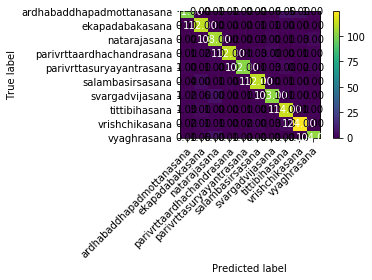

In [0]:
model = mobile_net_model

for layer in model.layers:
    layer.traiable = False
Dense_5 = Dense(1024,activation ='relu')(model.output)
Dense_4 = Dense(512,activation ='relu')(Dense_5)
Dense_3 = Dense(128,activation ='relu')(Dense_4)
Dense_2 = Dense(32,activation ='relu')(Dense_3)
output  = Dense(10,activation ='softmax')(Dense_2)


model = Model(inputs=model.inputs, outputs=output)
model.compile(Adam(lr = 0.001), loss = 'categorical_crossentropy',metrics =['accuracy'])

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=30)


model.fit_generator(train_generator, steps_per_epoch = train_steps,
                validation_data=val_generator, validation_steps=valid_steps,
                epochs=epoch, verbose=1,callbacks=[es])
model.evaluate_generator(val_generator,steps=valid_steps )

#save model into directory
model.save(drive_path +'MobileNet_model.h5')

test_generator.reset() #need to reset
predictions = model.predict_generator(test_generator,steps=test_steps,verbose=1)
pred_label=[np.argmax(image_class) for image_class in predictions]
labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred_label_class = [labels[k] for k in pred_label]
# pred_label_class

test_generator.reset() #need to reset
y_true = test_generator.classes

print(len(y_true),len(pred_label))
cm = confusion_matrix(y_true,pred_label)
print(cm)
plot_confusion_matrix(y_true, pred_label,cm)


testing_df = pd.DataFrame(y_true,columns = ['true_label'])
testing_df['pred_label'] = pred_label
testing_df['result'] = ''
for i, rows in enumerate(testing_df.result):
    if testing_df.loc[i,'true_label'] == testing_df.loc[i,'pred_label']:
        testing_df.loc[i,'result']= 1
    elif testing_df.loc[i,'true_label'] != testing_df.loc[i,'pred_label']:
        testing_df.loc[i,'result']= 0



In [0]:
test.reset_index(inplace = True,drop=True)
combine_test = pd.concat([test,testing_df], axis = 1)
combine_test.to_csv(drive_path +'MobileNet_test_df.csv')